## **Outliers Detection**

*Observation which deviates so much from other observations as to arouse suspicion it was generated by a different mechanism*<br>
*--- Hawkings (1980)*

### What is an anomalie

Outliers or anomalies are extreme values that deviate from other observations on data, they may indicate a variability in a measurement, experimental errors or a novelty. In other words, an outlier is an observation that diverges from an overall pattern on a sample. Outliers can be of two kinds: univariate and multivariate. Univariate outliers can be found when looking at a distribution of values in a single feature space. Multivariate outliers can be found in a n-dimensional space (of n-features). Looking at distributions in n-dimensional spaces can be very difficult for the human brain, that is why we need to train a model to do it for us.

### Anomaly detection is it not just Classification?

The answer is yes if the following three conditions are met.

- You have labeled training data
- Anomalous and normal classes are balanced ( say at least 1:5)
- Data is not autocorrelated. ( That one data point does not depend on earlier data points. This often breaks in time series data).

If all of above is true, we do not need an anomaly detection techniques and we can use an algorithm like Random Forests or Support Vector Machines (SVM). However, often it is very hard to find training data, and even when you can find them, most anomalies are 1:1000 to 1:10^6 events where classes are not balanced. Moreover, the most data, such as data from IoT use cases, would be autocorrelated.

Another aspect is that the false positives are a major concern as we will discuss under acting on decisions. Hence, the precision ( given model predicted an anomaly, how likely it is to be true)  and recall (how much anomalies the model will catch) trade-offs are different from normal classification use cases. We will discuss this in detail later.

### What is Anomaly Detection?

Anomalies or outliers come in three types.

- Point Anomalies. If an individual data instance can be considered as anomalous with respect to the rest of the data (e.g. purchase with large transaction value). Point outliers are single data points that lay far from the rest of the distribution.
- Contextual Anomalies. If a data instance is anomalous in a specific context, but not otherwise ( anomaly if occur at a certain time or a certain region. e.g. large spike at the middle of the night). 
- Collective Anomalies. If a collection of related data instances is anomalous with respect to the entire dataset, but not individual values. They have two variations. Events in unexpected order ( ordered. e.g. breaking rhythm in ECG) or Unexpected value combinations ( unordered. e.g. buying a large number of expensive items). Collective outliers can be subsets of novelties in data such as a signal that may indicate the discovery of new phenomena.

In the process of producing, collecting, processing and analyzing data, outliers can come from many sources and hide in many dimensions. Those that are not a product of an error are called **novelties**. Detecting outliers is of major importance for almost any quantitative discipline (ie: Physics, Economy, Finance, Machine Learning, Cyber Security). In machine learning and in any quantitative discipline the quality of data is as important as the quality of a prediction or classification model.

### Anomaly Detection Techniques

Anomaly detection can be approached in many ways depending on the nature of data and circumstances. Following is a classification of some of those techniques.

#### Static Rules Approach

**Standar deviation method (Z-Score)**

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers. The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 28.2 and the standard deviation is 6.5, as in the test dataset above, then all data in the sample between 34.7 and 21.7 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:
- 1 Standard Deviation from the Mean: 68%
- 2 Standard Deviations from the Mean: 95%
- 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

*Given mu and sigma, a simple way to identify outliers is to compute a z-score for every xi, which is defined as the number of standard deviations away xi is from the mean […] Data values that have a z-score sigma greater than a threshold, for example, of three, are declared to be outliers.*

#### Interquartile Range Method
Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution. A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short. The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots.

We can calculate the percentiles of a dataset using the `percentile()` NumPy function that takes the dataset and specification of the desired percentile. The IQR can then be calculated as the difference between the 75th and 25th percentiles.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.dates as mdates
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import scipy.io
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

In [2]:
column_names_dates = ['Timestamp', 'Module', 'Type', 'month',
       'year', 'day', 'week', 'hour', 'Temp_Mod', 'VBus', 'PT100(0)',
       'PT100(1)', 'LVL_Dim(1)', 'V_MPPT', 'V_Panel', 'LVL_Drain(1)', 'VBat',
       'V_Supp', 'Temp_Oil', 'Temp_gab', 'V_MPPT_TE', 'V_Panel_TE']

Modules={"00.57.FE.04":'Net-Coordinator',
         "00.57.FE.0E":'Radio-2.4 GHz',
         "00.57.FE.0F":'Radio-2.4 GHz',
         "00.57.FE.06":'Radio-2.4 GHz',
         "00.57.FE.09":'Radio-2.4 GHz',
         "00.57.FE.01":'Radio-2.4 GHz',
         "00.57.FE.05":'Radio-2.4 GHz',
         "00.57.FE.03":'Radio-2.4 GHz',
         "29.E5.5A.24":'Acq-Tempe',
         "A7.CB.0A.C0":'Acq-Current/Volt',
         "34.B2.9F.A9":'P-Solar Panel',
         "01.E9.39.32":'Acq-Current/Volt',
         "A4.0D.82.38":'P-AC/DC Input',
         "9F.8D.AC.91":'Acq-Tempe',
         "50.39.E2.80":'P-Solar Panel'}

In [3]:
# Loading the data
#df = pd.read_csv('Features.csv', usecols=column_names, parse_dates=['Timestamp'])

In [6]:
# Load dataset with dates
df = pd.read_csv('../../Features_Dates.csv', usecols=column_names_dates, parse_dates=['Timestamp'])
df['daylight'] = ((df['hour'] >= 7) & (df['hour'] <= 22)).astype(int)
df['time_epoch'] = (df['Timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [9]:
df.head()

,Timestamp,Module,Type,month,year,day,week,hour,Temp_Mod,VBus,...,V_Panel,LVL_Drain(1),VBat,V_Supp,Temp_Oil,Temp_gab,V_MPPT_TE,V_Panel_TE,daylight,time_epoch
0,2017-10-01 00:00:05,00.57.FE.04,Net-Coordinator,10,2017,1,39,0,25.3,4.736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15068160
1,2017-10-01 00:00:42,00.57.FE.04,Net-Coordinator,10,2017,1,39,0,25.3,4.743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15068160
2,2017-10-01 00:01:13,00.57.FE.04,Net-Coordinator,10,2017,1,39,0,25.3,4.743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15068160
3,2017-10-01 00:01:42,00.57.FE.04,Net-Coordinator,10,2017,1,39,0,25.3,4.743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15068161
4,2017-10-01 00:02:05,00.57.FE.04,Net-Coordinator,10,2017,1,39,0,25.3,4.743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15068161


## Removing Outliers from Dataframe WSN

### Using Statistical approaches like Histogram and Interquartile

In [7]:
df.groupby('Module').describe()

month                                                 \
                 count      mean       std  min  25%  50%   75%   max   
Module                                                                  
00.57.FE.01   440658.0  6.440341  3.613234  1.0  3.0  6.0  10.0  12.0   
00.57.FE.03   486828.0  6.684092  3.775161  1.0  3.0  7.0  10.0  12.0   
00.57.FE.04  2516426.0  6.692549  3.695085  1.0  3.0  7.0  10.0  12.0   
00.57.FE.05   584781.0  6.403460  3.670785  1.0  3.0  6.0  10.0  12.0   
00.57.FE.06   626840.0  6.692449  3.695422  1.0  3.0  7.0  10.0  12.0   
00.57.FE.09   323537.0  7.327737  3.317235  1.0  5.0  8.0  10.0  12.0   
00.57.FE.0E   514892.0  6.745362  3.648196  1.0  3.0  7.0  10.0  12.0   
00.57.FE.0F   622643.0  6.691078  3.697970  1.0  3.0  7.0  10.0  12.0   
01.E9.39.32   287468.0  6.635779  3.711126  1.0  3.0  7.0  10.0  12.0   
29.E5.5A.24   323891.0  6.705802  3.660809  1.0  3.0  7.0  10.0  12.0   
34.B2.9F.A9   167044.0  6.700402  3.654919  1.0  3.0  7.0  10.0  12.0   
50.39.E2.80   179294.0  6.619028  3.782032  1.0  3.0  7.0  10.0  12.0   
9F.8D.AC.91   305505.0  6.634448  3.780057  1.0  3.0  7.0  10.0  12.0   
A4.0D.82.38   228384.0  6.632470  3.712869  1.0  3.0  7.0  10.0  12.0   
A7.CB.0A.C0   238809.0  6.694982  3.663925  1.0  3.0  7.0  10.0  12.0   

                  year               ... daylight      time_epoch  \
                 count         mean  ...      75%  max      count   
Module                               ...                            
00.57.FE.01   440658.0  2018.126935  ...      1.0  1.0   440658.0   
00.57.FE.03   486828.0  2018.624621  ...      1.0  1.0   486828.0   
00.57.FE.04  2516426.0  2018.430964  ...      1.0  1.0  2516426.0   
00.57.FE.05   584781.0  2018.540190  ...      1.0  1.0   584781.0   
00.57.FE.06   626840.0  2018.432732  ...      1.0  1.0   626840.0   
00.57.FE.09   323537.0  2017.945026  ...      1.0  1.0   323537.0   
00.57.FE.0E   514892.0  2018.258305  ...      1.0  1.0   514892.0   
00.57.FE.0F   622643.0  2018.432783  ...      1.0  1.0   622643.0   
01.E9.39.32   287468.0  2018.447580  ...      1.0  1.0   287468.0   
29.E5.5A.24   323891.0  2018.262471  ...      1.0  1.0   323891.0   
34.B2.9F.A9   167044.0  2018.267696  ...      1.0  1.0   167044.0   
50.39.E2.80   179294.0  2018.668109  ...      1.0  1.0   179294.0   
9F.8D.AC.91   305505.0  2018.657718  ...      1.0  1.0   305505.0   
A4.0D.82.38   228384.0  2018.448337  ...      1.0  1.0   228384.0   
A7.CB.0A.C0   238809.0  2018.263449  ...      1.0  1.0   238809.0   

                                                                               \
                     mean            std         min          25%         50%   
Module                                                                          
00.57.FE.01  1.534292e+07  156139.403447  15068160.0  15211805.25  15344018.5   
00.57.FE.03  1.550655e+07  203752.087886  15068162.0  15377888.75  15528750.5   
00.57.FE.04  1.544561e+07  217929.084717  15068160.0  15256882.00  15445617.0   
00.57.FE.05  1.547245e+07  202481.662048  15121600.0  15297172.00  15472460.0   
00.57.FE.06  1.544616e+07  217831.426572  15068161.0  15257530.75  15445971.5   
00.57.FE.09  1.530884e+07  186631.940612  15068160.0  15174848.00  15272184.0   
00.57.FE.0E  1.539242e+07  194108.062782  15068160.0  15229097.75  15385435.5   
00.57.FE.0F  1.544614e+07  217842.546310  15068160.0  15257497.50  15446251.0   
01.E9.39.32  1.544934e+07  215381.196545  15068160.0  15263463.25  15451864.0   
29.E5.5A.24  1.539268e+07  191361.281970  15068160.0  15231422.00  15387196.0   
34.B2.9F.A9  1.539419e+07  190545.253124  15068161.0  15234486.50  15388983.5   
50.39.E2.80  1.551857e+07  195493.397499  15068166.0  15396711.75  15539287.5   
9F.8D.AC.91  1.551569e+07  197563.827227  15068165.0  15392265.00  15536844.0   
A4.0D.82.38  1.544949e+07  215280.516550  15068161.0  15263600.25  15452170.5   
A7.CB.0A.C0  1.539271e+07  190532.027062  15068161.0  15232076.00  15387740.0   



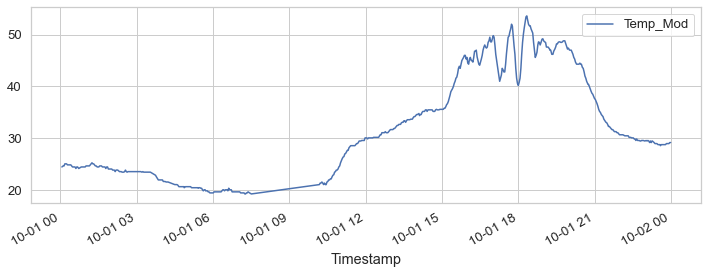

In [8]:
# Take a look to the sample 6000 to 6600 of temperatures
df.loc[6000:6600].plot(x='Timestamp', y = 'Temp_Mod', figsize=(12,4))
plt.show()

In [10]:
def get_outliers(df, Modules, k_factor=1.5, std_times=3, verbose=True, remove=True, method='z_score'):
    
    '''
    This function identifies outliers in a Dataset.
    Two methods can be used, z_score and interquartile.
    If the data follos a Gaussian like distribution Z_score 
    can be used, if not is better to use the interquartile method. 
    This are not very good estimation since some of this outliers can be
    noveltys (correct data that explains something that happens
    or viceversa)
    k_factor: factor for interquartile method
    std_times: how many standard deviations away from the mean
               for Z_Score method
    df: Original Dataframe
    remove: If False don't remove the outliers
    Modules: Dictionary type
    '''
    
    # Dataframe to save Outliers by Modules
    df_outliers = pd.DataFrame(data=None)
    
    for module in Modules:
        # Take a slice of the dataset by module
        slice_of_data = df[df['Module']== module]
        # Drop Useless Columns (columns with all nan values)
        slice_of_data = slice_of_data.dropna(axis=1, how='all')
        if method == 'z_score':
            # calculate summary statistics
            mean, std = slice_of_data['Temp_Mod'].mean().round(4), slice_of_data['Temp_Mod'].std().round(4)
            # identify outliers outside 3 standar deviations
            cut_off = std * std_times
            lower, upper = mean - cut_off, mean + cut_off
            # identify outliers
            outliers = [x for x in slice_of_data['Temp_Mod'] if x < lower or x > upper]
            # save outliers in dataframe
            df_outliers = pd.concat([df_outliers, pd.Series(outliers, name=module, dtype=float)], axis=1)
            #print(Counter(outliers))
            outliers_removed = [x for x in slice_of_data['Temp_Mod'] if x > lower and x < upper]
            
            if verbose == True:    
                print('Outliers indentified: {} in module {}'.format(len(outliers), module))
                print('Non-outlier observations: {} in module {}'.format(len(outliers_removed), module))
        
        if method == 'interquartile':
            q25, q75 = np.percentile(slice_of_data['Temp_Mod'], 25), np.percentile(slice_of_data['Temp_Mod'], 75)
            IQR = q75 - q25
            cut_off = IQR * k_factor
            lower, upper = q25 - cut_off, q75 + cut_off
            outliers = [x for x in slice_of_data['Temp_Mod'] if x < lower or x > upper]
            outliers_removed = [x for x in slice_of_data['Temp_Mod'] if x >= lower and x <= upper]
            # save outliers in dataframe
            df_outliers = pd.concat([df_outliers, pd.Series(outliers, name=module, dtype=float)], axis=1)
            
            if verbose == True:    
                print('Percentiles 25th = {} 75th = {} IQR = {}'.format(q25, q75, IQR.round(3)))
                print('Outliers indentified {}'.format(len(outliers)))
                print('Non-outlier observations: %d' % len(outliers_removed))
            
    
        # Remove the Outliers
        if remove == True:    
            for ii in np.unique(outliers):
                if verbose == True:
                    print('Removing {} from Module {}'.format(ii, module))
                else:
                    slice_of_data = df[df['Module']== module]
                    indexx = slice_of_data[slice_of_data['Temp_Mod'] == ii].index
                    df = df.drop(df.index[indexx], axis=0)
                    df.reset_index(inplace=True, drop=True)
    
    return df_outliers, df 

In [12]:
df2 = df
df_outliers, df2 = get_outliers(df2, Modules, std_times=3, verbose=True, remove=True)

Outliers indentified: 65532 in module 00.57.FE.04
Non-outlier observations: 2450894 in module 00.57.FE.04
Removing 34.0 from Module 00.57.FE.04
Removing 34.2 from Module 00.57.FE.04
Removing 34.4 from Module 00.57.FE.04
Removing 34.6 from Module 00.57.FE.04
Removing 34.8 from Module 00.57.FE.04
Removing 35.0 from Module 00.57.FE.04
Removing 35.2 from Module 00.57.FE.04
Removing 35.5 from Module 00.57.FE.04
Removing 35.6 from Module 00.57.FE.04
Removing 35.8 from Module 00.57.FE.04
Removing 36.1 from Module 00.57.FE.04
Removing 36.2 from Module 00.57.FE.04
Removing 36.5 from Module 00.57.FE.04
Removing 36.7 from Module 00.57.FE.04
Removing 36.9 from Module 00.57.FE.04
Removing 37.1 from Module 00.57.FE.04
Removing 37.3 from Module 00.57.FE.04
Removing 37.5 from Module 00.57.FE.04
Removing 37.7 from Module 00.57.FE.04
Removing 37.9 from Module 00.57.FE.04
Removing 38.1 from Module 00.57.FE.04
Removing 38.3 from Module 00.57.FE.04
Removing 38.5 from Module 00.57.FE.04
Removing 38.7 from M

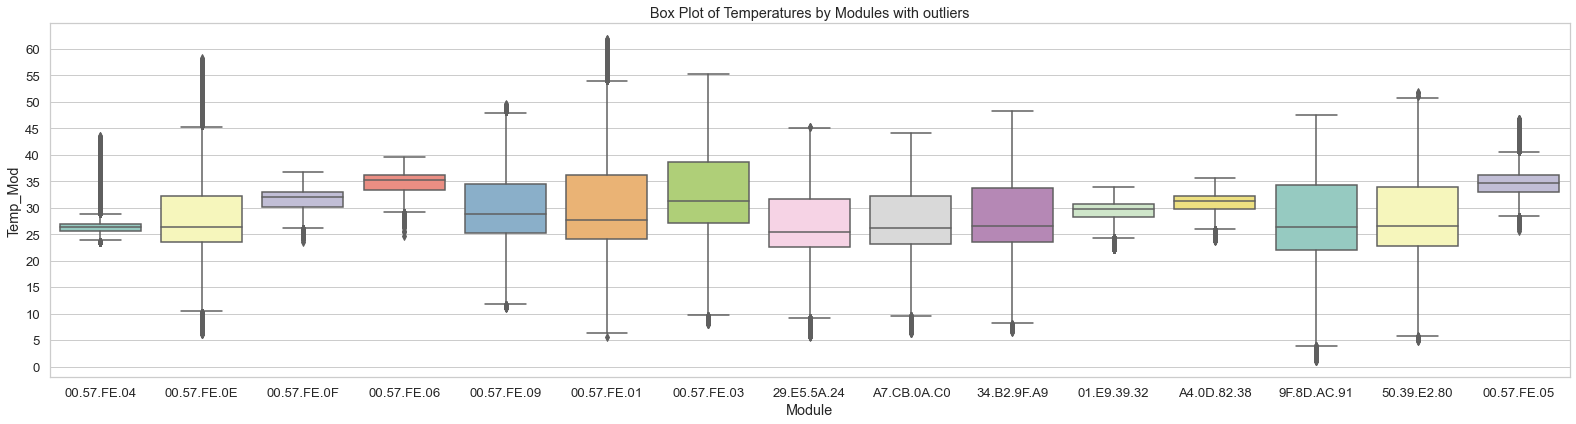

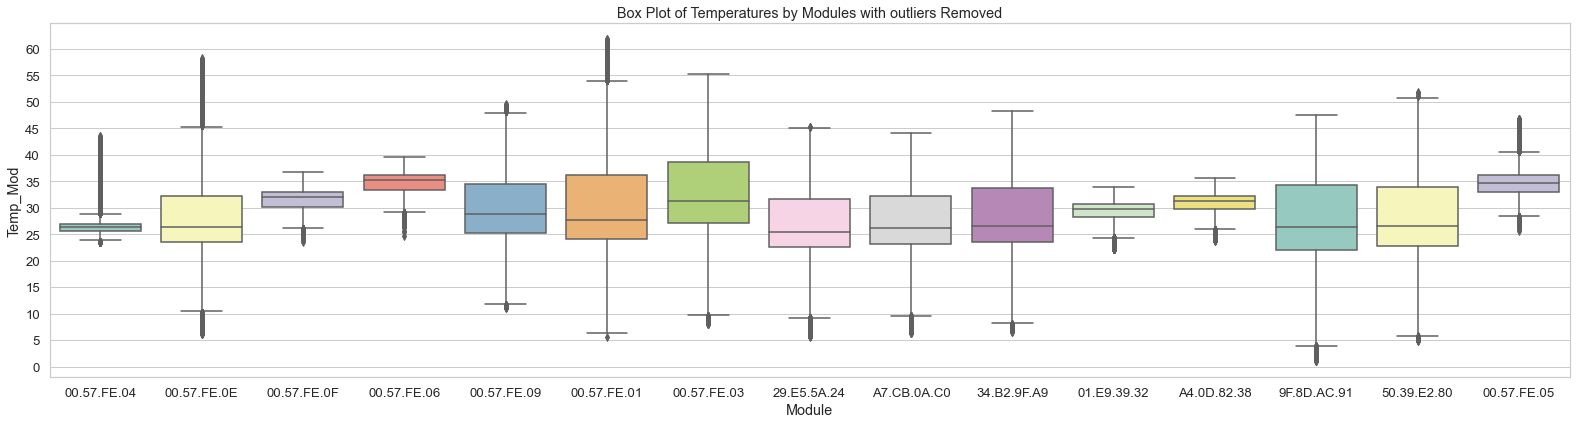

In [13]:
plt.figure(figsize=(22,6))
plt.title('Box Plot of Temperatures by Modules with outliers')
sns.boxplot(x='Module',y='Temp_Mod',data=df, palette='Set3')
plt.yticks(ticks=np.arange(0,65,step=5))
#plt.xticks(rotation=60)
plt.tight_layout()
plt.figure(figsize=(22,6))
plt.title('Box Plot of Temperatures by Modules with outliers Removed')
sns.boxplot(x='Module',y='Temp_Mod',data=df2, palette='Set3', fliersize=5)
plt.yticks(ticks=np.arange(0,65,step=5))
#plt.xticks(rotation=60)
plt.tight_layout()

We can see that a considerably amounth of outliers was removed, now, there is no ensurance that all this data were in fact outliers. Therefor, a more accurate method of detection of outliers must be implemented. If we make a `pd.describe()` we can see the amounth of possible outliers by module

In [14]:
df_outliers.describe().loc[['count']]

,00.57.FE.04,00.57.FE.0E,00.57.FE.0F,00.57.FE.06,00.57.FE.09,00.57.FE.01,00.57.FE.05,00.57.FE.03,29.E5.5A.24,A7.CB.0A.C0,34.B2.9F.A9,01.E9.39.32,A4.0D.82.38,9F.8D.AC.91,50.39.E2.80
count,65532.0,3288.0,1796.0,2014.0,19.0,931.0,3306.0,233.0,240.0,167.0,53.0,742.0,622.0,194.0,48.0


In [17]:
# Locate entry with some outliers
slice_of_data= df[df['Module']== '34.B2.9F.A9']
slice_of_data = slice_of_data.dropna(axis=1, how='all')
slice_of_data[slice_of_data['Temp_Mod']==df_outliers['34.B2.9F.A9'][10]]

,Timestamp,Module,Type,month,year,day,week,hour,Temp_Mod,VBus,V_MPPT,V_Panel,daylight,time_epoch
6031249,2019-07-07 05:58:44,34.B2.9F.A9,P-Solar Panel,7,2019,7,27,5,7.9,3.266,3.268,0.000,0,15624791
6031250,2019-07-07 06:03:57,34.B2.9F.A9,P-Solar Panel,7,2019,7,27,6,7.9,3.254,3.259,0.000,0,15624794
6031290,2019-07-07 11:08:56,34.B2.9F.A9,P-Solar Panel,7,2019,7,27,11,7.9,3.236,3.237,15.745,1,15624977


Above is an example of possible outliers detected in the original dataset. The temperature of 7.9 degrees is considered an outlier in module 34.B2.9F.A9, but we can see that in 2 cases this temperature correspond to a Voltage Panel of 0 Volts, meaning there was no Sun, also, the timestamp indicates that it was early in the morning and all values are in the same day, therefor, there is a possibility that this is a valid value, and also, all the points in the vecinity are close to this value so the possibility is that it was just a very cold day. <br>
This are **collective outliers**. The 3rd example does looks suspicious, since the Panel was generating good voltage (15 Volts) and it was almost noon. But, wee saw that there is some correlation between this features (V_Panel and Temperature). This is why is needed a stronger method for outlier detection.

A safe bet also is to use wisdom of the crowds by using multiple ensemble methods. We can then choose to combine them through majority vote, or union or intersection of the individual algorithms’ verdicts.

### **Trying other methods for anomaly detection**

Conventional statistical methods are generally more interpretable and sometimes more useful than machine learning-based methods, depending on the specified problem. Some are Holt-Winters(Triple Exponential Smoothing), ARIMA (Auto-Regressive Integrated Moving Average) and Histogram-Based Outlier Detection (HBOS).

Machine Learning methods can model more complex data and hence able to detect more complex anomalies than conventional statistical methods. Thety can be Supervised (e.g. Decision Tree, SVM, LSTM Forecasting), Unsupervised (e.g. K-Means, Hierarchical Clustering, DBSCAN, Isolation Forest), Self-Supervised (e.g. LSTM Autoencoder) and the data represented in Points, Rolling Window (or trajectory matrix) or Time Series Features (transformations, decompositions and statistical measurements).

In [9]:
# get a slice of the data, drop the NaN columns and reset index
slice_of_data= df[df['Module']== '34.B2.9F.A9']
slice_of_data = slice_of_data.dropna(axis=1, how='all')
slice_of_data.reset_index(inplace=True, drop=True)

In [19]:
slice_of_data.head()

,Timestamp,Module,Type,month,year,day,week,hour,Temp_Mod,VBus,V_MPPT,V_Panel,daylight,time_epoch
0,2017-10-01 00:03:19,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.4,3.279,3.290,0.000,0,15068161
1,2017-10-01 00:08:13,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.2,3.281,3.290,0.321,0,15068164
2,2017-10-01 00:13:14,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.1,3.282,3.281,0.262,0,15068167
3,2017-10-01 00:18:24,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.0,3.278,3.281,0.233,0,15068171
4,2017-10-01 00:31:59,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,19.9,3.280,3.290,0.350,0,15068179


### Cluster only (K-Means)
##### Use for collective anomalies. 

We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

#### Take useful feature and standardize them

In [65]:
data = slice_of_data[['Temp_Mod', 'hour', 'daylight', 'day', 'VBus', 'V_MPPT','V_Panel']]

In [66]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data))
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

In [67]:
# standardize these 2 new features and create dataframe
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data))

#### Calculate with different number of centroids to see the loss plot (elbow method)

In [68]:
n_cluster = range(1, 25)  # 25 centroids
kmeans = [KMeans(n_clusters = i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

In [69]:
# create dataframe with scores
df_scores = pd.DataFrame(np.array([scores, n_cluster]).transpose(), columns=['Scores', 'N_Clusters'])

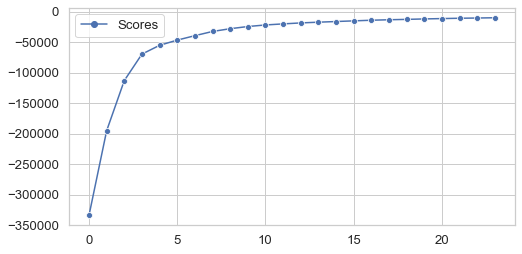

In [70]:
plt.figure(figsize=(8,4))
sns.lineplot(data=df_scores[['Scores']], markers=True)
plt.show()

#### Choose 20 centroids arbitrarily and add these data to the central dataframe

In [71]:
slice_of_data['cluster'] = kmeans[20].predict(data)
slice_of_data['principal_feature1'] = data[0]
slice_of_data['principal_feature2'] = data[1]
#slice_of_data['cluster'].value_counts()

In [72]:
slice_of_data.head()

,Timestamp,Module,Type,month,year,day,week,hour,Temp_Mod,VBus,V_MPPT,V_Panel,daylight,time_epoch,cluster,principal_feature1,principal_feature2
0,2017-10-01 00:03:19,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.4,3.279,3.290,0.000,0,15068161,12,-1.2269,-1.5638
1,2017-10-01 00:08:13,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.2,3.281,3.290,0.321,0,15068164,12,-1.2217,-1.5649
2,2017-10-01 00:13:14,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.1,3.282,3.281,0.262,0,15068167,12,-1.2407,-1.5662
3,2017-10-01 00:18:24,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.0,3.278,3.281,0.233,0,15068171,12,-1.2518,-1.5671
4,2017-10-01 00:31:59,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,19.9,3.280,3.290,0.350,0,15068179,12,-1.2321,-1.5665


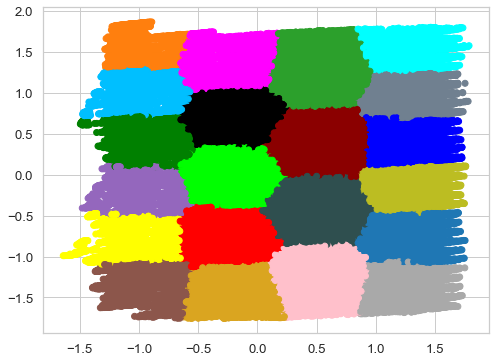

In [73]:
#plot the different clusters with the 2 main features
colors = {0:'blue', 1:'red', 2:'green', 3:'pink', 4:'cyan', 5:'magenta', 
          6:'yellow', 7:'black', 8:'tab:blue', 9:'tab:orange', 10:'tab:green', 11: 'tab:purple',
          12:'tab:brown', 13:'tab:olive', 14: 'darkslategray', 15:'lime', 16:'darkgray', 
          17:'goldenrod', 18:'deepskyblue', 19:'slategray', 20:'darkred'}
plt.figure(figsize=(8,6))
plt.scatter(slice_of_data['principal_feature1'], slice_of_data['principal_feature2'], c=slice_of_data["cluster"].apply(lambda x: colors[x]))
plt.show()

#### Get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly

In [74]:
def getDistanceByPoint(data, model):
    distance = pd.Series(data=None, dtype=float)
    for i in range(0, len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [75]:
distance = getDistanceByPoint(data, kmeans[20])

In [76]:
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [77]:
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
slice_of_data['anomaly21'] = (distance >= threshold).astype(int)
print('Number of Anomalies {}'.format(number_of_outliers))
print('Threshold distance for anomaly {}'.format(threshold))

Number of Anomalies 1670
Threshold distance for anomaly 3.453781966436012


#### Visualisation of anomaly with cluster view and in Times Series Form

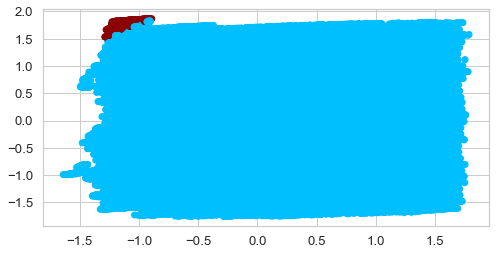

In [78]:
colors = {0:'deepskyblue', 1:'darkred'}
plt.figure(figsize=(8,4))
plt.scatter(slice_of_data['principal_feature1'], slice_of_data['principal_feature2'], c=slice_of_data["anomaly21"].apply(lambda x: colors[x]))
plt.show()

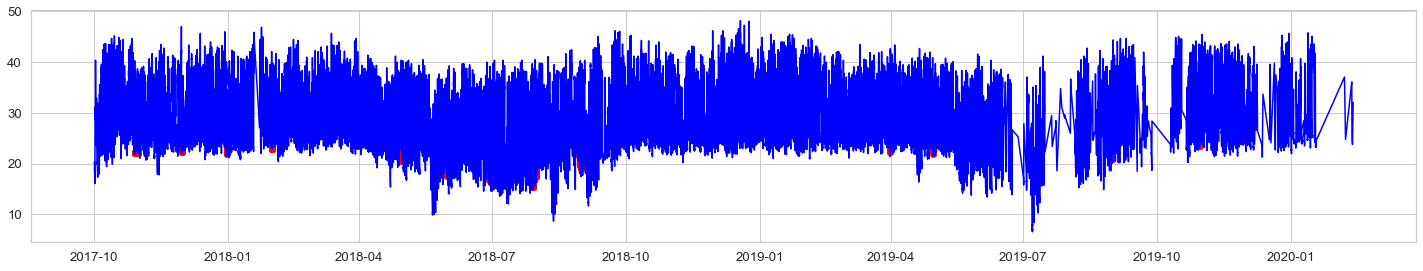

In [79]:
# visualisation of anomaly throughout time
anomaly = slice_of_data.loc[slice_of_data['anomaly21'] == 1, ['Timestamp', 'Temp_Mod']] #anomaly
plt.figure(figsize=(20,4))
plt.plot(slice_of_data['Timestamp'], slice_of_data['Temp_Mod'], color='blue')
plt.scatter(anomaly['Timestamp'],anomaly['Temp_Mod'], color='red')
plt.tight_layout()

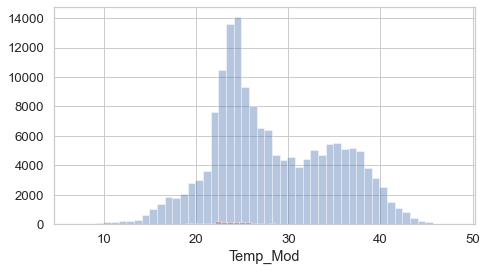

In [80]:
plt.figure(figsize=(7,4))
sns.distplot(a=slice_of_data['Temp_Mod'], kde=False)
sns.distplot(a=anomaly['Temp_Mod'], kde=False, color='r')
plt.tight_layout()

**As we can see, K-means detected anomalies in the mid values of temperatures, but almost nothing in the extremes**

### Gaussian only

We will separate data by (what we think of) important categories. Or we can separate data based on different cluster. Then we find outliers (gaussian repartition, unimodal) by categories independently.   

In [82]:
# apply ellipticEnvelope(gaussian distribution) at all temperatures
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = slice_of_data['Temp_Mod'].values.reshape(-1,1)
envelope.fit(X_train)

EllipticEnvelope(assume_centered=False, contamination=0.01, random_state=None,
                 store_precision=True, support_fraction=None)

In [83]:
deviation = envelope.decision_function(X_train)
slice_of_data['anomaly_ell_evp'] = envelope.predict(X_train)

In [84]:
slice_of_data.head()

,Timestamp,Module,Type,month,year,day,week,hour,Temp_Mod,VBus,V_MPPT,V_Panel,daylight,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21,anomaly_ell_evp
0,2017-10-01 00:03:19,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.4,3.279,3.290,0.000,0,15068161,12,-1.2269,-1.5638,0,1
1,2017-10-01 00:08:13,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.2,3.281,3.290,0.321,0,15068164,12,-1.2217,-1.5649,0,1
2,2017-10-01 00:13:14,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.1,3.282,3.281,0.262,0,15068167,12,-1.2407,-1.5662,0,1
3,2017-10-01 00:18:24,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,20.0,3.278,3.281,0.233,0,15068171,12,-1.2518,-1.5671,0,1
4,2017-10-01 00:31:59,34.B2.9F.A9,P-Solar Panel,10,2017,1,39,0,19.9,3.280,3.290,0.350,0,15068179,12,-1.2321,-1.5665,0,1


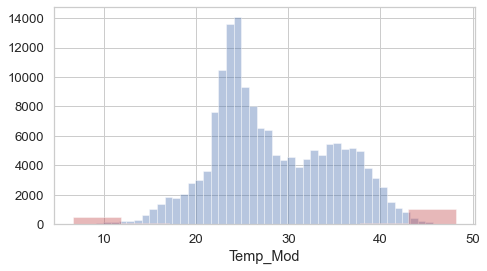

In [85]:
# anomalies marked as -1
anomaly = slice_of_data.loc[slice_of_data['anomaly_ell_evp'] == -1, ['Timestamp', 'Temp_Mod']] #anomaly
plt.figure(figsize=(7,4))
sns.distplot(a=slice_of_data['Temp_Mod'], kde=False)
sns.distplot(a=anomaly['Temp_Mod'], kde=False, color='r')
plt.tight_layout()

The elliptical envelope method has a good detection of extreme values.

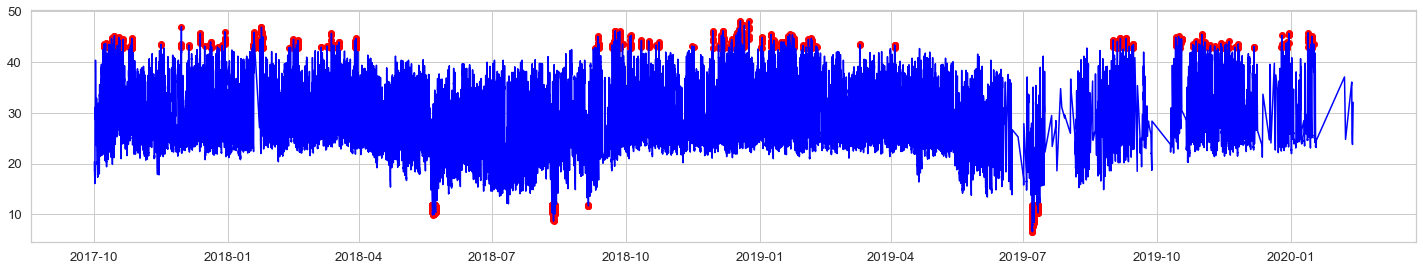

In [86]:
# here we can see the time series
plt.figure(figsize=(20,4))
plt.plot(slice_of_data['Timestamp'], slice_of_data['Temp_Mod'], color='blue')
plt.scatter(anomaly['Timestamp'],anomaly['Temp_Mod'], color='red')
plt.tight_layout()

### **Isolation Forest**

#### Use for collective anomalies (unordered). 

Isolation forest is a machine learning algorithm for anomaly detection. It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data.

Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.

In general the first step to anomaly detection is to construct a profile of what's "normal", and then report anything that cannot be considered normal as anomalous. However, the isolation forest algorithm does not work on this principle; it does not first define "normal" behavior, and it does not calculate point-based distances. The Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, which should make them easier to identify. Isolation Forest uses an ensemble of Isolation Trees for the given data points to isolate anomalies.

Isolation Forest recursively generates partitions on the dataset by randomly selecting a feature and then randomly selecting a split value for the feature. Presumably the anomalies need fewer random partitions to be isolated compared to "normal" points in the dataset, so the anomalies will be the points which have a smaller path length in the tree, path length being the number of edges traversed from the root node.

*Using Isolation Forest, we can not only detect anomalies faster but we also require less memory compared to other algorithms.*

#### Define the data and standarize it

In [117]:
# Take useful feature and standardize them 
data = slice_of_data[['Temp_Mod', 'hour', 'daylight', 'day', 'VBus', 'V_MPPT','V_Panel']]

In [118]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data))

#### Define and fit the model

We'll create a model variable and instantiate the IsolationForest class. We are passing the values of four parameters to the Isolation Forest method, listed below. 

- Number of estimators: n_estimators refers to the number of base estimators or trees in the ensemble, i.e. the number of trees that will get built in the forest. This is an integer parameter and is optional. The default value is 100.

- Max samples: max_samples is the number of samples to be drawn to train each base estimator. If max_samples is more than the number of samples provided, all samples will be used for all trees. The default value of max_samples is 'auto'. If 'auto', then max_samples=min(256, n_samples)

- Contamination: This is a parameter that the algorithm is quite sensitive to; it refers to the expected proportion of outliers in the data set. This is used when fitting to define the threshold on the scores of the samples. The default value is 'auto'. If ‘auto’, the threshold value will be determined as in the original paper of Isolation Forest.

- Max features: All the base estimators are not trained with all the features available in the dataset. It is the number of features to draw from the total features to train each base estimator or tree.The default value of max features is one.

In [134]:
# train isolation forest 
model =  IsolationForest(contamination=outliers_fraction, n_estimators=50, max_samples='auto', max_features=1.0)
model.fit(data)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=50,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [135]:
# add the data to the main
slice_of_data['scores_isolation_f'] = pd.Series(model.decision_function(data))
slice_of_data['anomaly_IsolationF'] = pd.Series(model.predict(data))
slice_of_data['anomaly_IsolationF'] = slice_of_data['anomaly_IsolationF'].map( {1: 0, -1: 1} )
print(slice_of_data['anomaly_IsolationF'].value_counts())

0    165373
1      1671
Name: anomaly_IsolationF, dtype: int64


To print the predicted anomalies in the data we need to analyse the data after addition of scores and anomaly column. As you can see above for the predicted anomalies the anomaly column values would be -1 and their scores will be negative.

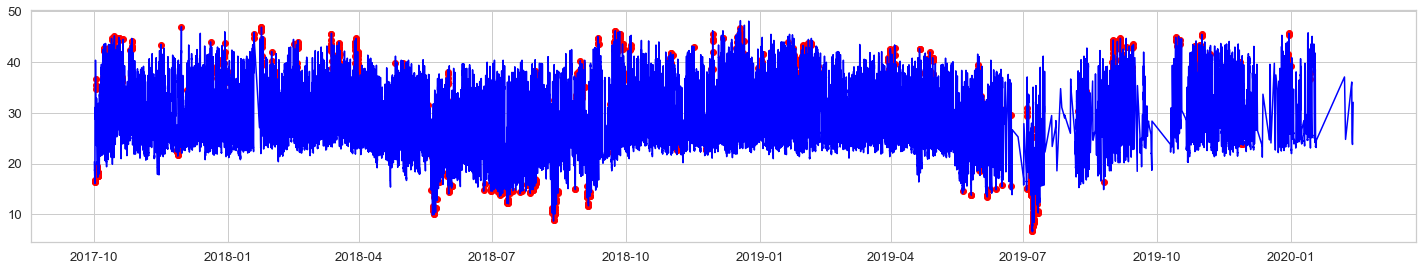

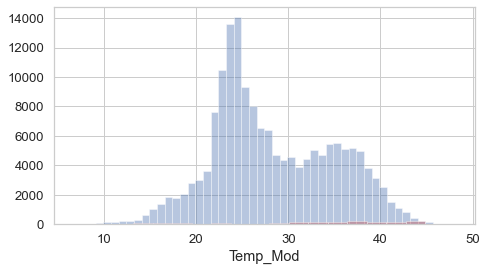

In [136]:
# Locate anomalies
anomaly = slice_of_data.loc[slice_of_data['anomaly_IsolationF'] == 1, ['Timestamp', 'Temp_Mod']] #anomaly
# Print anomalies
plt.figure(figsize=(20,4))
plt.plot(slice_of_data['Timestamp'], slice_of_data['Temp_Mod'], color='blue')
plt.scatter(anomaly['Timestamp'], anomaly['Temp_Mod'], color='red')
plt.tight_layout()

plt.figure(figsize=(7,4))
sns.distplot(a=slice_of_data['Temp_Mod'], kde=False)
sns.distplot(a=anomaly['Temp_Mod'], kde=False, color='r')
plt.tight_layout()

### **One class SVM (Use for collective anomalies (unordered)).**

Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [95]:
# Take useful feature and standardize them 
data = slice_of_data[['Temp_Mod', 'hour', 'daylight', 'day', 'VBus', 'V_MPPT','V_Panel']]

In [96]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data))

In [97]:
# train isolation forest 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
model.fit(data)
# add the data to the main  
slice_of_data['anomaly_SVM'] = pd.Series(model.predict(data))
slice_of_data['anomaly_SVM'] = slice_of_data['anomaly_SVM'].map( {1: 0, -1: 1} )
print(slice_of_data['anomaly_SVM'].value_counts())

0    165452
1      1592
Name: anomaly_SVM, dtype: int64


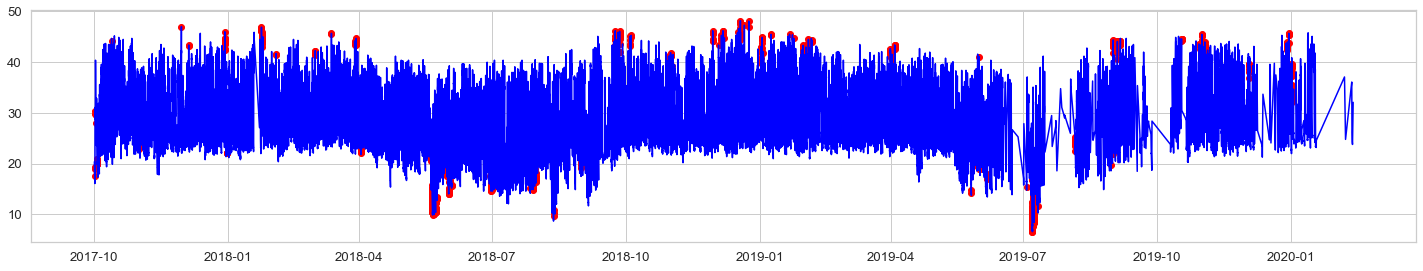

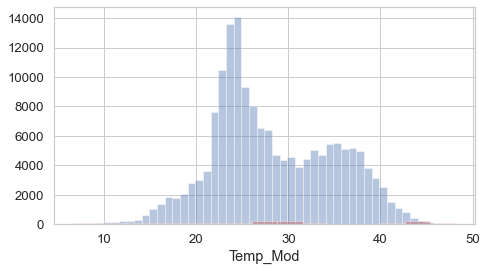

In [98]:
anomaly = slice_of_data.loc[slice_of_data['anomaly_SVM'] == 1, ['Timestamp', 'Temp_Mod']] #anomaly
plt.figure(figsize=(20,4))
plt.plot(slice_of_data['Timestamp'], slice_of_data['Temp_Mod'], color='blue')
plt.scatter(anomaly['Timestamp'], anomaly['Temp_Mod'], color='red')
plt.tight_layout()

plt.figure(figsize=(7,4))
sns.distplot(a=slice_of_data['Temp_Mod'], kde=False)
sns.distplot(a=anomaly['Temp_Mod'], kde=False, color='r')
plt.tight_layout()

Give result similar to isolation forest but find some anomalies in average values. Difficult to know if it's relevant.

### LSTM with multivariate features
#### Use for  sequential anomalies (ordered)

The basic idea of anomaly detection with LSTM neural network is this: the system looks at the previous values over hours or days and predicts the behavior for the next minute. If the actual value a minute later is within, let’s say, one standard deviation, then there is no problem. If it is more it is an anomaly.

So, LSTM is used to look for anomalies in a period of time, but not in the entire dataset, although, it can be runned over different parts of the dataset.  These types of networks excel at finding complex relationships in multivariate time series data.

The idea is to separete the data in a sequence and the label for that sequence is going to be the number we want to predict. Keep in mind that we can decide how long the training sequence is going to be and how long the label we want to predict. We can also edit how many sequences per batch.

#### The First thing to do is Scale the data

In [10]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [11]:
# Take useful feature and standardize them 
data = slice_of_data[['Temp_Mod', 'hour', 'daylight', 'day', 'VBus', 'V_MPPT','V_Panel']]
scaler = StandardScaler()
# Scale the data and convert it into dataframe for easy splitting
data = pd.DataFrame(scaler.fit_transform(data), columns=['Temp_Mod', 'hour', 'daylight', 'day', 'VBus', 'V_MPPT','V_Panel'])

In [52]:
data.shape

(167044, 7)

In [12]:
# important parameters and train/test size
prediction_time = 1 
test_size = 1000
unroll_length = 50
testdatacut = test_size + unroll_length  + 1

#### Split into train and testing sets

In [13]:
# Get the index for splitting
test_ind = len(data)- test_size - unroll_length

In [14]:
# Split the data and convert to numpy
X_train = data.iloc[:test_ind].to_numpy()
X_test = data.iloc[test_ind:].to_numpy()
# The y train are the values of the feature i want to predict
y_train = X_train[:,0]
y_test = X_test[:,0]

In [15]:
print('Index for splitting {}'.format(test_ind))
print('X_train shape {}'.format(X_train.shape))
print('X_test shape {}'.format(X_test.shape))
print('y_train shape {}'.format(y_train.shape))
print('y_test shape {}'.format(y_test.shape))

Index for splitting 165994
X_train shape (165994, 7)
X_test shape (1050, 7)
y_train shape (165994,)
y_test shape (1050,)


#### Create segments of data

In [16]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data, length=50):
    result = []
    for index in range(len(data) - length):
        result.append(data[index: index + length])
    return np.asarray(result)

In [17]:
# adapt the datasets for the sequence data shape
X_train = unroll(data=X_train, length=unroll_length)
X_test  = unroll(data=X_test, length=unroll_length)

In [18]:
y_train = y_train[-X_train.shape[0]:]
y_test  = y_test[-X_test.shape[0]:]

In [19]:
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (165944, 50, 7)
y_train (165944,)
x_test (1000, 50, 7)
y_test (1000,)


#### Train model

In [20]:
n_features=7

In [23]:
# define model
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(unroll_length, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 1)             36        
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 1)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dropout_4 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train the model
history= model.fit(X_train, y_train, batch_size=3028, epochs=1, validation_split=0.1)

Train on 149349 samples, validate on 16595 samples
Epoch 1/1
149349/149349 [==============================] - 5s 36us/step - loss: 0.9993 - val_loss: 1.0126


In [26]:
# create the list of difference between prediction and test data
error=[]
ratio=[]
predictions = model.predict(X_test)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for ii in range(len(y_test)):
    pr = predictions[ii][0]
    ratio.append((y_test[ii]/pr)-1)
    error.append(abs(y_test[ii]- pr))

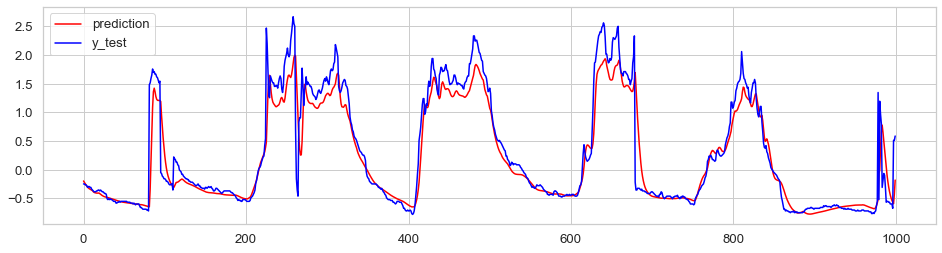

In [286]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots(figsize=(16,4))
axs.plot(predictions, color='red', label='prediction')
axs.plot(y_test, color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [27]:
# select the most distant prediction/reality data points as anomalies
outliers_fraction = 0.05
error = pd.Series(error)
number_of_outliers = int(outliers_fraction * len(error))
threshold = error.nlargest(number_of_outliers).min()
print('The threshold is {}'. format(threshold))
print('Number of outliers is {}'. format(number_of_outliers))

The threshold is 2.025506077632214
Number of outliers is 50


In [54]:
# data with anomaly label (test data part)
test = (error >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data)-test_size))

In [55]:
# # add the data to the main
slice_of_data['anomaly_LSTM'] = complement.append(test, ignore_index='True')

In [58]:
slice_of_data['anomaly_LSTM'].value_counts()

0    166993
1        51
Name: anomaly_LSTM, dtype: int64

In [48]:
print(slice_of_data['anomaly_LSTM'].value_counts())

0    166993
1        51
Name: anomaly_LSTM, dtype: int64


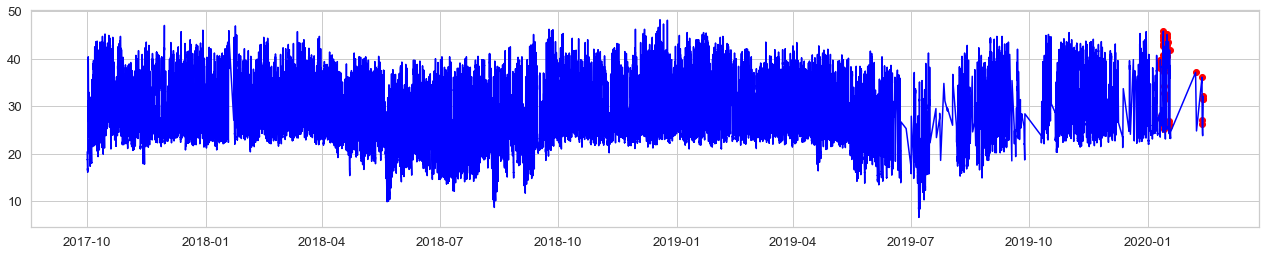

In [296]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(22,4))
a = slice_of_data.loc[slice_of_data['anomaly_LSTM'] == 1, ['Timestamp', 'Temp_Mod']] #anomaly

ax.plot(slice_of_data['Timestamp'], slice_of_data['Temp_Mod'], color='blue')
ax.scatter(a['Timestamp'],a['Temp_Mod'], color='red')
plt.show()

### LSTM with TimeseriesGenerator

This generator creates the batches, but the training takes too long

In [226]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [240]:
data = slice_of_data[['Timestamp','Temp_Mod', 'hour', 'daylight', 'day', 'VBus', 'V_MPPT','V_Panel']].iloc[0:20000]

In [241]:
test_ind = len(data)- test_size - unroll_length

In [242]:
# Split the data and convert to numpy
X_train = data.iloc[:test_ind]
X_test = data.iloc[test_ind:]

In [243]:
X_train.set_index('Timestamp', inplace=True)
X_test.set_index('Timestamp', inplace=True)

In [244]:
X_train.head()

,Temp_Mod,hour,daylight,day,VBus,V_MPPT,V_Panel
Timestamp,,,,,,,
2017-10-01 00:03:19,20.4,0,0,1,3.279,3.290,0.000
2017-10-01 00:08:13,20.2,0,0,1,3.281,3.290,0.321
2017-10-01 00:13:14,20.1,0,0,1,3.282,3.281,0.262
2017-10-01 00:18:24,20.0,0,0,1,3.278,3.281,0.233
2017-10-01 00:31:59,19.9,0,0,1,3.280,3.290,0.350


In [245]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [246]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [248]:
# define generator
length = 50 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(data=X_train_scaled, targets=X_train_scaled[:,0], length=length, batch_size=batch_size)

In [249]:
len(generator)

18900

In [250]:
X,y = generator[0]

In [251]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.13915858 0.         0.         0.         0.1375     0.17522659
 0.         0.13268608 0.         0.         0.         0.14375
 0.17522659 0.01556515 0.12944984 0.         0.         0.
 0.146875   0.14803625 0.01270426 0.12621359 0.         0.
 0.         0.134375   0.14803625 0.01129807 0.12297735 0.
 0.         0.         0.140625   0.17522659 0.01697134 0.12297735
 0.         0.         0.         0.146875   0.14803625 0.
 0.12297735 0.         0.         0.         0.134375   0.14803625
 0.01129807 0.1197411  0.         0.         0.         0.13125
 0.14803625 0.0014062  0.1197411  0.04347826 0.         0.
 0.134375   0.17522659 0.01697134 0.11326861 0.04347826 0.
 0.         0.13125    0.16012085 0.01697134 0.11326861 0.04347826
 0.         0.         0.14375    0.16012085 0.01697134 0.11326861
 0.04347826 0.         0.         0.13125    0.14803625 0.
 0.11326861 0.04347826 0.         0.         0.134375   0.16012085
 0.01697134 0.11326861 0.04347826 0.   

In [252]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [253]:
X_train_scaled.shape

(18950, 7)

In [254]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(1,input_shape=(length, X_train_scaled.shape[1])))
# Final Prediction (one neuron per feature)
# model.add(Dense(X_train_scaled.shape[1]))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1)                 36        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [255]:
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(X_test_scaled,X_test_scaled, 
                                           length=length, batch_size=3028)

In [ ]:
model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

## K-means 10 clusters

In [66]:
data = slices[1][slices[0].columns[3:]]

In [67]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data))
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

In [68]:
# standardize these 2 new features and create dataframe
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data))

#### Calculate with different number of centroids to see the loss plot (elbow method)

In [21]:
n_cluster = range(1, 25)  # 25 centroids
kmeans = [KMeans(n_clusters = i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

In [22]:
# create dataframe with scores
df_scores = pd.DataFrame(np.array([scores, n_cluster]).transpose(), columns=['Scores', 'N_Clusters'])

In [79]:
#plt.figure(figsize=(8,4))
#sns.lineplot(data=df_scores[['Scores']], markers=True)
#plt.show()

#### Choose 10 centroids arbitrarily and add these data to the central dataframe

In [69]:
slices[1]['cluster'] = kmeans[10].predict(data)
slices[1]['principal_feature1'] = data[0]
slices[1]['principal_feature2'] = data[1]
#slices[1]['cluster'].value_counts()

#### Get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly

In [70]:
def getDistanceByPoint(data, model):
    distance = pd.Series(data=None, dtype=float)
    for i in range(0, len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [71]:
distance = getDistanceByPoint(data, kmeans[10])

In [72]:
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.02

In [73]:
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# anomaly_Kmeans contain the anomaly result of method Cluster (0:normal, 1:anomaly) 
slices[1]['anomaly_Kmeans'] = (distance >= threshold).astype(int)
print('Number of Anomalies {}'.format(number_of_outliers))
print('Threshold distance for anomaly {}'.format(threshold))

Number of Anomalies 10297
Threshold distance for anomaly 3.7249893043918036


#### Visualisation of anomaly with cluster view and in Times Series Form

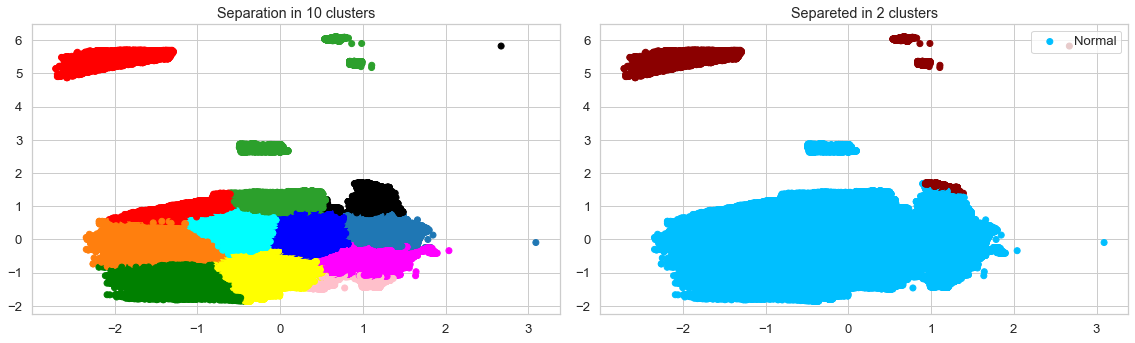

In [75]:
#plot the different clusters with the 2 main features
colors = {0:'blue', 1:'red', 2:'green', 3:'pink', 4:'cyan', 5:'magenta', 
          6:'yellow', 7:'black', 8:'tab:blue', 9:'tab:orange', 10:'tab:green', 11: 'tab:purple',
          12:'tab:brown', 13:'tab:olive', 14: 'darkslategray', 15:'lime', 16:'darkgray', 
          17:'goldenrod', 18:'deepskyblue', 19:'slategray', 20:'darkred'}

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax1.scatter(slices[1]['principal_feature1'], slices[1]['principal_feature2'], c=slices[1]["cluster"].apply(lambda x: colors[x]))
ax1.set_title('Separation in 10 clusters')

colors = {0:'deepskyblue', 1:'darkred'}
ax2.set_title('Separeted in 2 clusters')
ax2.scatter(slices[1]['principal_feature1'], slices[1]['principal_feature2'], c=slices[1]["anomaly_Kmeans"].apply(lambda x: colors[x]))
ax2.legend(labels=(['Normal','Anomaly']),loc='upper right')
plt.tight_layout()

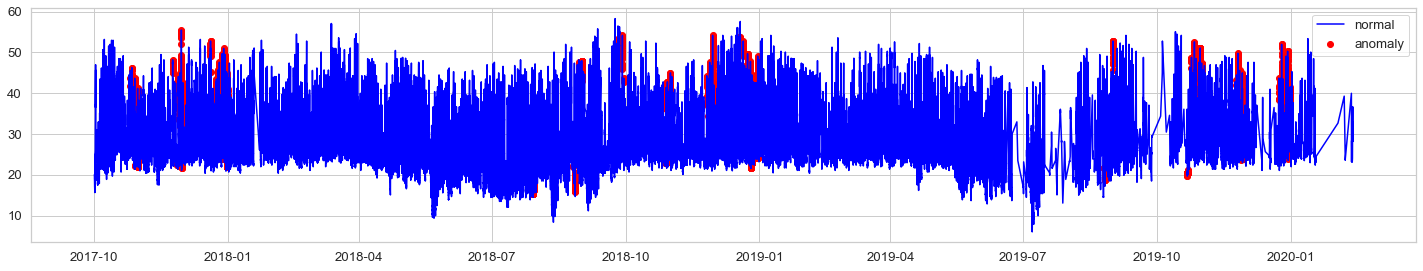

In [76]:
# visualisation of anomaly throughout time
anomaly = slices[1].loc[slices[1]['anomaly_Kmeans'] == 1, ['Timestamp', 'Temp_Mod']] #anomaly
plt.figure(figsize=(20,4))
plt.plot(slices[1]['Timestamp'], slices[1]['Temp_Mod'], color='blue', label='normal')
plt.scatter(anomaly['Timestamp'],anomaly['Temp_Mod'], color='red', label='anomaly')
plt.legend()
plt.tight_layout()

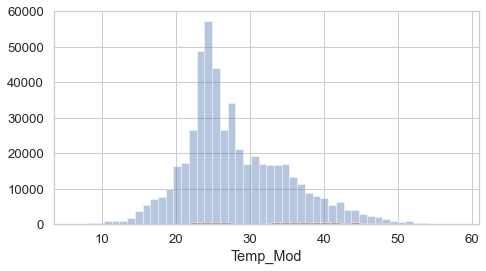

In [78]:
plt.figure(figsize=(7,4))
sns.distplot(a=slices[1]['Temp_Mod'], kde=False)
sns.distplot(a=anomaly['Temp_Mod'], kde=False, color='r')
plt.tight_layout()